# PRIMER PARCIAL
1. Nombre: Gutierrez Coronado Matias Ezequiel
2. Carrera: Ingenieria de Sistemas

# Clasificación One-vs-All con Regresión Logística


## 1. Preprocesamiento adecuado en el dataset

### Librerias importadas

In [1]:
# Importamos las librerías necesarias para manipulación de datos, optimización y visualización
import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
import pandas as pd
from sklearn.model_selection import train_test_split


### Carga y selección de características del dataset

In [2]:
# Cargamos el dataset y seleccionamos las características de entrada y la etiqueta (Quartil)
dataset_path = 'economicdata_2002-2022.csv'
data = pd.read_csv(dataset_path)
X = data[['Economic Freedom Summary Index', 'Size of Government', 
                'Legal Sys & Prop. Rights', 'Sound Money', 
                'Freedom to trade internationally', 'Regulation']].values
y = data['Quartile'].values 
num_labels = 4
m = y.size

## 2. Normalización de las caracteristicas


In [3]:
def featureNormalize(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma
    
# Normaliza las características X y guarda la media y desviación estándar
X_norm, mu, sigma = featureNormalize(X)


## 3. División del dataset en entrenamiento y prueba

In [4]:
# Dividimos el dataset en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

## 4. Definición e implementación del modelo


In [5]:
# Función sigmoide: Convierte cualquier valor z en un valor entre 0 y 1
def sigmoid(z):
    return 1 / (1 + np.exp(-z))  



In [6]:
# Función de costo y gradiente para la regresión logística con regularización (One-vs-All)
def lrCostFunction(theta, X, y, lambda_, cost_history=None):
    m = y.size
    if y.dtype == bool:
        y = y.astype(int)
    J = 0
    grad = np.zeros(theta.shape)
    h = sigmoid(X.dot(theta.T))

    temp = theta
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X)
    grad = grad + (lambda_ / m) * temp

    if cost_history is not None:
        cost_history.append(J)

    return J, grad

## 5. Definición y establecimiento de los valores óptimos de los hiperparámetros


In [7]:
# Entrenamiento de un clasificador One-vs-All para cada clase
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))  # Inicializamos los parámetros para cada clase
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadimos el término de sesgo

    cost_history = {}

    for c in np.arange(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 100}  # Establecemos el número máximo de iteraciones para la optimización
        cost_class_history = []
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_, cost_class_history),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c] = res.x
        cost_history[f'Clase {c}'] = cost_class_history

    return all_theta, cost_history

In [8]:
# Entrenamos el modelo One-vs-All con un valor de regularización lambda_ y mostramos los parámetros entrenados
lambda_ = 0.04
all_theta, cost_history = oneVsAll(X_train, y_train, num_labels, lambda_)
print(all_theta.shape)
print(all_theta)

(4, 7)
[[-10.23394272   3.88241915   2.70065904   4.55013522   2.61630785
    3.34353905   0.96768284]
 [ -1.31227784   0.11291859   0.28945696  -1.18703262   0.65846297
    0.40679247   0.69327059]
 [ -1.13891102  -2.47902558   0.53173607   0.43776278   0.56767413
    0.48808215   0.56673898]
 [ -7.53063799  -2.62038371  -1.58428368  -2.7022604   -2.11949523
   -1.9722831   -0.89166473]]


## 6. Entrenamiento de los modelos

In [9]:
# Predicción One-vs-All: Realiza predicciones para cada clase utilizando los parámetros entrenados
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    num_labels = all_theta.shape[0]
    p = np.zeros(m)

    X = np.concatenate([np.ones((m, 1)), X], axis=1)
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis=1)

    return p


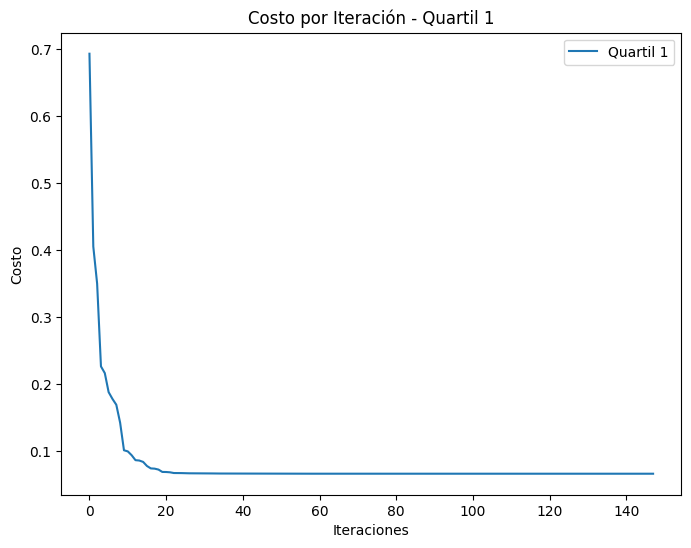

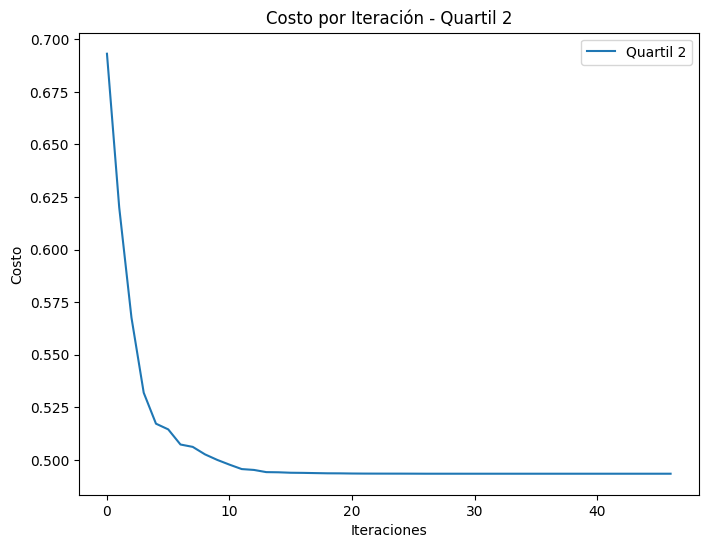

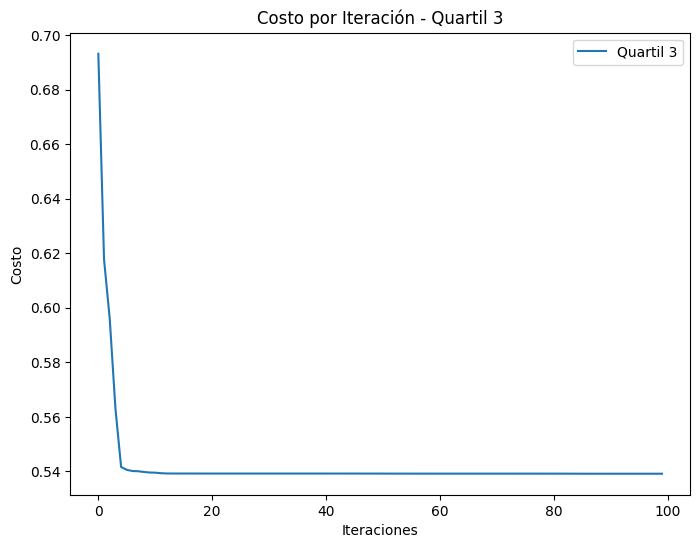

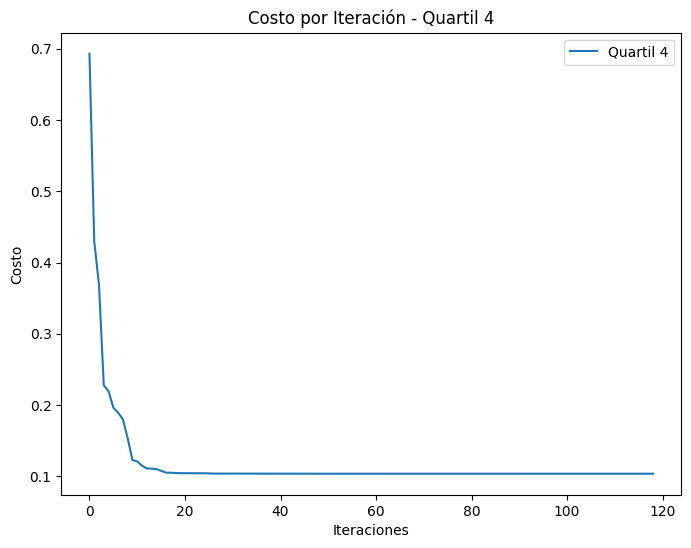

In [10]:
# Graficamos el costo por iteración para cada quartil (clase) durante el entrenamiento
for i in range(num_labels):  
    num_iterations = len(cost_history[f'Clase {i}'])
    plt.figure(figsize=(8, 6))
    plt.plot(range(num_iterations), cost_history[f'Clase {i}'], label=f'Quartil {i+1}')
    plt.xlabel('Iteraciones')
    plt.ylabel('Costo')
    plt.title(f'Costo por Iteración - Quartil {i+1}')
    plt.legend()
    plt.show()


## 7. Prueba de los modelos


In [11]:
# Realizamos predicciones sobre los conjuntos de entrenamiento y prueba, y mostramos la precisión

print(X_train.shape)
print(X_test.shape)
pred_train = predictOneVsAll(all_theta, X_train)
print('Precision del conjunto de entrenamiento: {:.2f}%'.format(np.mean(pred_train == y_train) * 100))

XPrueba = X_test[100:150, :].copy()
print(XPrueba.shape)

XPrueba = np.concatenate([np.ones((50, 1)), XPrueba], axis=1)
print(XPrueba.shape)

p = np.argmax(sigmoid(XPrueba.dot(all_theta.T)), axis=1)
print(p)

print(y_test[100:150])


(2531, 6)
(633, 6)
Precision del conjunto de entrenamiento: 81.19%
(50, 6)
(50, 7)
[2 0 0 0 3 0 3 3 0 3 0 0 0 3 1 2 1 3 1 0 1 3 3 0 3 3 3 2 0 2 2 3 0 3 3 0 2
 3 0 0 1 3 0 0 2 1 2 0 3 0]
[2. 0. 0. 0. 3. 0. 3. 3. 0. 2. 0. 0. 0. 2. 1. 1. 1. 3. 1. 0. 0. 3. 3. 0.
 3. 3. 3. 2. 0. 2. 2. 3. 0. 3. 3. 1. 2. 2. 0. 0. 1. 2. 0. 0. 2. 1. 2. 0.
 3. 0.]


## 8. Interpretación de los resultados

### Interpretacion de los graficos

Quartil 1: El costo disminuye rápidamente y luego se estabiliza, lo cual indica que el modelo está aprendiendo correctamente, pero no se logra una separación perfecta, lo que es normal en modelos One-vs-All.

Quartil 2 y 3: El costo se estabiliza cerca de 0.50, lo que sugiere que el modelo tiene dificultades para diferenciar claramente estas clases. Esto puede deberse a que las características de estos quartiles son similares a las de otros.

Quartil 4: El costo baja a 0.1, lo cual es una señal positiva. Un costo tan bajo muestra que el modelo tiene confianza al clasificar este quartil, lo que indica que las características son separables.

### Interpretacion de la prueba del modelo


La precisión del 81.19% en el conjunto de entrenamiento es bastante buena, especialmente considerando que estamos utilizando un modelo One-vs-All para clasificación multiclase. En este enfoque, el modelo entrena un clasificador para cada clase, tratando de distinguir esa clase de las demás. Debido a esto, pueden ocurrir dificultades para separar algunas clases de manera clara, sobre todo cuando las características de las clases no son completamente diferenciables entre sí. 

# REDES NEURONALES


## 1. Preprocesamiento adecuado en el dataset

### Librerias importadas

In [12]:
# Librerías principales para el modelo y visualización
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


### Carga y selección de características del dataset

In [13]:
# Cargamos el dataset y seleccionamos las características de entrada y la etiqueta (Quartil)
dataset_path = 'economicdata_2002-2022.csv'
data = pd.read_csv(dataset_path)
X = data[['Economic Freedom Summary Index', 'Size of Government', 
                'Legal Sys & Prop. Rights', 'Sound Money', 
                'Freedom to trade internationally', 'Regulation']].values
y = data['Quartile'].values 

## 2. Normalización de las caracteristicas

In [14]:
# Normalizamos las características con la media y desviación estándar
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convertimos los datos normalizados a tensores
X_tensor = torch.tensor(X_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

## 3. División del dataset en entrenamiento y prueba

In [15]:
# Dividimos el dataset en conjuntos de entrenamiento (80%) y prueba (20%) para evaluar el modelo
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [16]:
# Combina las entradas y etiquetas en un solo objeto TensorDataset para facilitar el manejo de datos con DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
print(len(train_data))
print(len(test_data))


2531
633


## 4. Definición e implementación del modelo

In [17]:
# Red neuronal con una capa oculta
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)   # 1 capa oculta con 32 neuronas
        self.output = nn.Linear(32, num_classes)  # Capa de salida (4 clases)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU como activación para la capa oculta
        x = self.output(x)           # Capa de salida
        return torch.softmax(x, dim=1)  # Softmax para clasificación multiclase

input_size = X_train.shape[1]  
num_classes = len(np.unique(y_train)) 


## 5. Definición y establecimiento de los valores óptimos de los hiperparámetros

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Configura GPU si está disponible

# Inicializa el modelo y mueve a la GPU o CPU
model = NeuralNetwork(input_size=input_size, num_classes=num_classes).to(device) 

# Configurar la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam

# DataLoader para entrenamiento: carga en batches de 8 y mezcla los datos
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
# DataLoader para prueba: carga en batches de 8 sin mezclar
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

## 6. Entrenamiento de los modelos

In [19]:
# Entrenamiento de la red neuronal durante 100 épocas, calculando la pérdida y precisión en cada época
epochs = 100
train_loss = []
train_accuracy = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch 1/100, Loss: 1.1940, Accuracy: 56.38%
Epoch 2/100, Loss: 1.0267, Accuracy: 79.02%
Epoch 3/100, Loss: 0.9552, Accuracy: 84.95%
Epoch 4/100, Loss: 0.9204, Accuracy: 86.65%
Epoch 5/100, Loss: 0.9017, Accuracy: 87.59%
Epoch 6/100, Loss: 0.8909, Accuracy: 87.12%
Epoch 7/100, Loss: 0.8847, Accuracy: 87.71%
Epoch 8/100, Loss: 0.8796, Accuracy: 88.31%
Epoch 9/100, Loss: 0.8756, Accuracy: 88.07%
Epoch 10/100, Loss: 0.8730, Accuracy: 88.31%
Epoch 11/100, Loss: 0.8709, Accuracy: 88.34%
Epoch 12/100, Loss: 0.8695, Accuracy: 88.15%
Epoch 13/100, Loss: 0.8679, Accuracy: 88.27%
Epoch 14/100, Loss: 0.8668, Accuracy: 88.15%
Epoch 15/100, Loss: 0.8659, Accuracy: 88.31%
Epoch 16/100, Loss: 0.8652, Accuracy: 88.27%
Epoch 17/100, Loss: 0.8636, Accuracy: 88.31%
Epoch 18/100, Loss: 0.8631, Accuracy: 88.27%
Epoch 19/100, Loss: 0.8627, Accuracy: 88.54%
Epoch 20/100, Loss: 0.8619, Accuracy: 88.82%
Epoch 21/100, Loss: 0.8629, Accuracy: 88.70%
Epoch 22/100, Loss: 0.8611, Accuracy: 88.62%
Epoch 23/100, Loss:

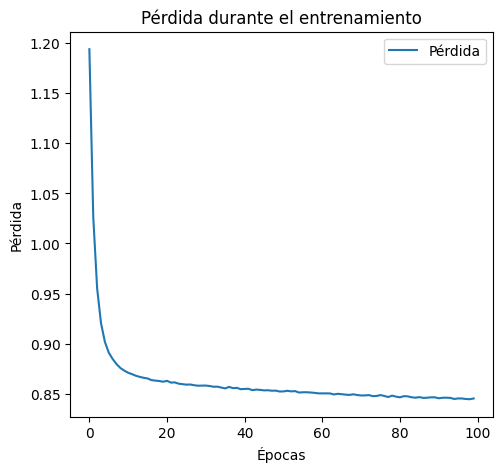

In [20]:
# 7. Graficando la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Pérdida")
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

## 7. Prueba de los modelos

In [23]:
# Evaluación del modelo en el conjunto de prueba y cálculo de la precisión
model.eval()
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\nPrecisión en el conjunto de prueba: {test_accuracy:.2f}%")


Precisión en el conjunto de prueba: 90.52%


In [22]:
# Seleccionamos 20 ejemplos aleatorios del conjunto de prueba
random_indices = np.random.choice(len(predictions), size=20, replace=False)

# Mostramos las predicciones aleatorias junto con las etiquetas reales
print("\nAlgunas predicciones aleatorias vs etiquetas reales en el conjunto de prueba:")
for i in random_indices:
    print(f"Predicción: {predictions[i]}, Real: {true_labels[i]}")


Algunas predicciones aleatorias vs etiquetas reales en el conjunto de prueba:
Predicción: 2, Real: 2
Predicción: 2, Real: 2
Predicción: 0, Real: 0
Predicción: 0, Real: 0
Predicción: 3, Real: 3
Predicción: 3, Real: 3
Predicción: 3, Real: 2
Predicción: 1, Real: 1
Predicción: 0, Real: 0
Predicción: 0, Real: 0
Predicción: 0, Real: 0
Predicción: 1, Real: 1
Predicción: 0, Real: 0
Predicción: 3, Real: 3
Predicción: 2, Real: 2
Predicción: 3, Real: 3
Predicción: 3, Real: 3
Predicción: 0, Real: 0
Predicción: 2, Real: 2
Predicción: 3, Real: 3


## 8. Interpretación de los resultados

### Interpretacion de los graficos

La pérdida disminuye rápidamente al principio, lo que significa que el modelo está aprendiendo bien. Sin embargo, después de un tiempo, la curva se estabiliza alrededor de 0.85. Esto es normal porque el modelo ha llegado a un punto donde ya no puede mejorar mucho más. Al principio, hace grandes ajustes en los pesos, pero luego, conforme aprende, las mejoras son más pequeñas. La pérdida se queda ahí porque el modelo ya está bastante optimizado y sigue funcionando bien. 

### Interpretacion de la prueba del modelo

Con una precisión del 90.52% en el conjunto de prueba, el modelo está haciendo un excelente trabajo, acertando 9 de cada 10 predicciones. Esto indica que ha aprendido bien y puede generalizar a datos nuevos de manera efectiva.

# 9. Conclusiones

Ll modelo One-vs-All tiene la ventaja de ser sencillo y eficiente para problemas con clases claramente separables. Sin embargo, cuando las clases son similares, como ocurrió con los Quartiles 2 y 3, puede ser difícil para el modelo diferenciarlas correctamente, ya que cada clase se aprende por separado, lo que crea incertidumbres. Además, este enfoque requiere entrenar un clasificador por cada clase, lo cual se vuelve costoso en conjuntos de datos grandes.

Por otro lado, las redes neuronales son capaces de aprender patrones más complejos y manejar mejor las interacciones entre clases. Aunque son más complicadas de entrenar y requieren más recursos, su capacidad para generalizar a datos nuevos es más alta. De hecho, la red neuronal mostró un 90.52% de precisión en el conjunto de prueba, lo que es superior al rendimiento del modelo One-vs-All (81.19%).

En este caso, la red neuronal resulta ser la mejor opción, ya que maneja mejor la complejidad de las clases y tiene una mayor capacidad para generalizar.